In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import ast


In [25]:
## Matplotlib defaults

plt.style.use("default")

plt.rcParams.update({"font.size" : 22})

# Full "Causality" figure

Why does MA increase over time? Explores:

1. Cost
2. Network degree
3. Individual authors
4. Companies (assignees)
5. Patent classifications

## Novel compounds

Goal is to show how novel compounds are driving MA changes...

In [13]:
MA_df_months = pd.read_csv("../Data/AssemblyValues/MA_df_months.csv")
MA_df_months["date"] = pd.to_datetime(MA_df_months["date"])
MA_df_months["month"] = MA_df_months["month"].to_string()
MA_df_months["avg"] = pd.to_numeric(MA_df_months["avg"])

MA_df_months = MA_df_months[MA_df_months["date"] >= "1980"]

In [14]:
def get_month(label):
    """ Isolates the month from the given label

    Args:
        label (str): compound id in the form YYYY-MM_label

    Returns:
        str: YYYY-MM of a particular compound
    """
    return str(label)[:7]

In [32]:
new_df = pd.read_csv("../Data/AssemblyValues/NewDatabase_AssemblyGo.csv")
new_df["month"] = new_df["label"].apply(get_month)
new_df = new_df.dropna()

new_stats = new_df.groupby(["month"]).agg({"MA_assemblyGo":["mean","std"]})
new_stats = new_stats.dropna(axis=0)


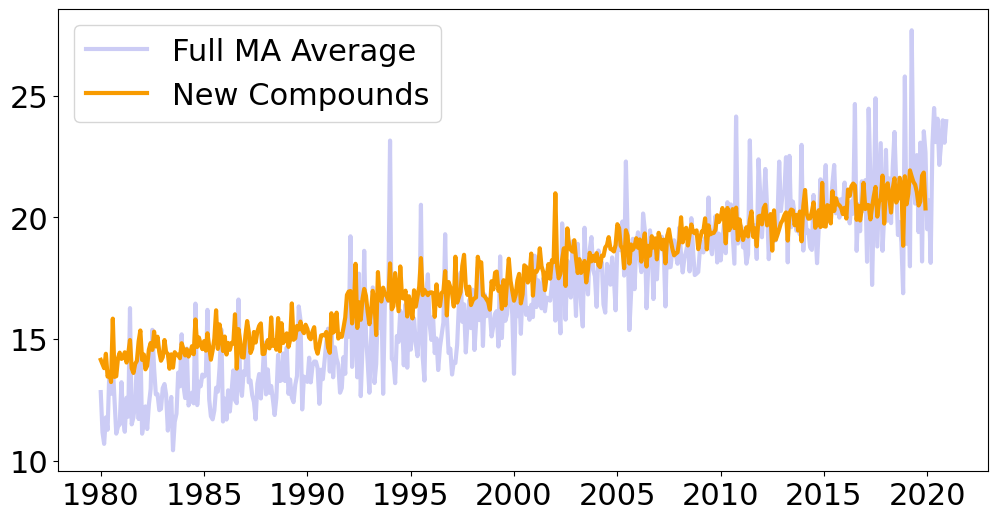

In [36]:
plt.figure(figsize=(12,6))

plt.plot(MA_df_months["date"], MA_df_months["avg"], color="mediumblue",
            linewidth=3, markersize=10, alpha=0.2, label="Full MA Average")

plt.plot(list(MA_df_months["date"])[:-12], new_stats["MA_assemblyGo"]["mean"], color="#f89b00",
            linewidth=3, markersize=10, label="New Compounds")

plt.legend()

## Cost

Individually plot cost figure

In [15]:
cost_df = pd.read_csv("/Volumes/Macintosh HD 4/SureChemBL/Cost/random_cost_50k_MA.csv")

print(cost_df)

       Unnamed: 0  Unnamed: 0.1           CAS     price  \
0               0        312645     2446-69-7   13.5664   
1               1        217713           NaN   75.9000   
2               2        144938     1759-55-3   58.8000   
3               3         81564  2095410-18-5  421.1000   
4               4        171801  1864299-18-2  169.3000   
...           ...           ...           ...       ...   
49995       49995         14022    21243-02-7  130.0000   
49996       49996         18129  1057326-92-7  151.7000   
49997       49997        214453   923034-27-9  403.5000   
49998       49998         11443    50617-74-8  151.7000   
49999       49999        308529  1214900-87-4  867.3600   

                                                    name    supplier  \
0                           4-Hexylphenol >= 98.0 % HPLC       sigma   
1                    3,6-dichloropyrazine-2-carbonitrile     enamine   
2                 2,2-dimethylcyclopropane-1-carboxamide     enamine   
3  

In [16]:
## Remove all "unfinished" MA calculations - unfinished are those that didn't finish in 300 seconds

cost_df_filtered = cost_df[cost_df["time"] <= 299]

## Also removing all -1 MA values
cost_df_filtered = cost_df_filtered[cost_df_filtered["MA"] > 0]

print(cost_df_filtered)

       Unnamed: 0  Unnamed: 0.1           CAS     price  \
0               0        312645     2446-69-7   13.5664   
1               1        217713           NaN   75.9000   
2               2        144938     1759-55-3   58.8000   
3               3         81564  2095410-18-5  421.1000   
4               4        171801  1864299-18-2  169.3000   
...           ...           ...           ...       ...   
49995       49995         14022    21243-02-7  130.0000   
49996       49996         18129  1057326-92-7  151.7000   
49997       49997        214453   923034-27-9  403.5000   
49998       49998         11443    50617-74-8  151.7000   
49999       49999        308529  1214900-87-4  867.3600   

                                                    name    supplier  \
0                           4-Hexylphenol >= 98.0 % HPLC       sigma   
1                    3,6-dichloropyrazine-2-carbonitrile     enamine   
2                 2,2-dimethylcyclopropane-1-carboxamide     enamine   
3  

In [17]:
## Testing - changing cost to log scale
cost_df_filtered["log_price"] = np.log(cost_df_filtered["price"])

print(cost_df_filtered)

       Unnamed: 0  Unnamed: 0.1           CAS     price  \
0               0        312645     2446-69-7   13.5664   
1               1        217713           NaN   75.9000   
2               2        144938     1759-55-3   58.8000   
3               3         81564  2095410-18-5  421.1000   
4               4        171801  1864299-18-2  169.3000   
...           ...           ...           ...       ...   
49995       49995         14022    21243-02-7  130.0000   
49996       49996         18129  1057326-92-7  151.7000   
49997       49997        214453   923034-27-9  403.5000   
49998       49998         11443    50617-74-8  151.7000   
49999       49999        308529  1214900-87-4  867.3600   

                                                    name    supplier  \
0                           4-Hexylphenol >= 98.0 % HPLC       sigma   
1                    3,6-dichloropyrazine-2-carbonitrile     enamine   
2                 2,2-dimethylcyclopropane-1-carboxamide     enamine   
3  

SpearmanrResult(correlation=0.12541840009179364, pvalue=4.3269813358019165e-161)


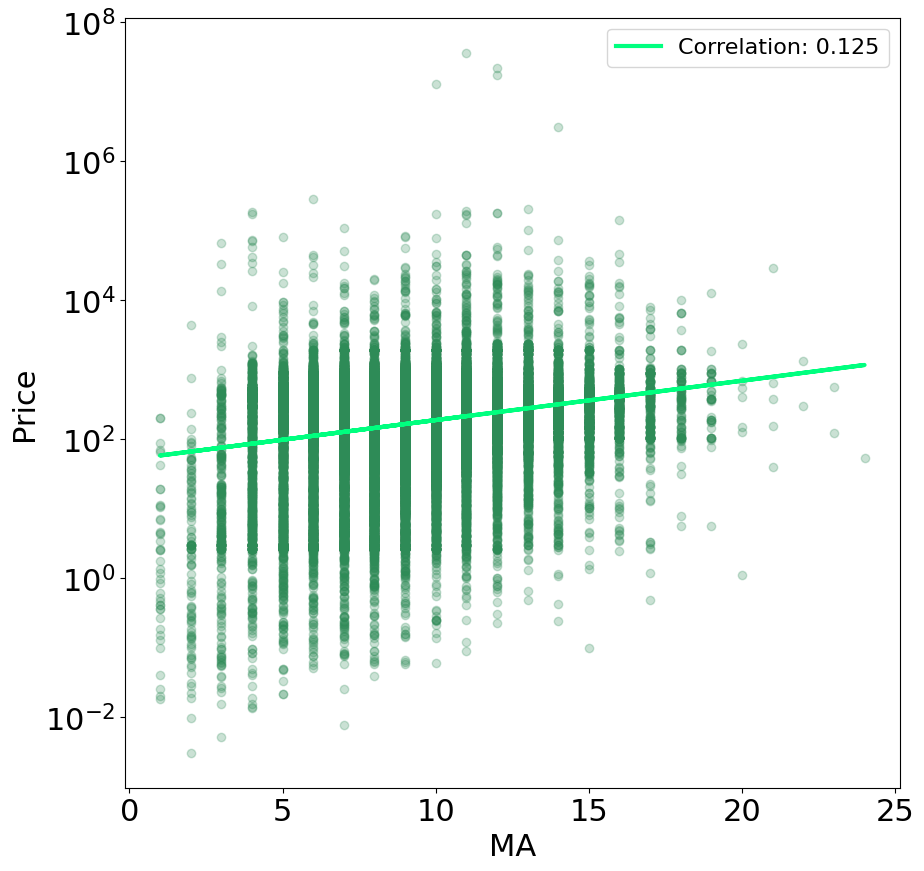

In [6]:
plt.figure(figsize=(10,10))

plt.yscale("log")

cost_df_filtered = cost_df_filtered.sort_values("price")

plt.scatter(cost_df_filtered["MA"], cost_df_filtered["price"], alpha=0.25, color="seagreen")
# sns.kdeplot(data=cost_df_filtered, x="MA", y="price", fill=True, color="seagreen", alpha=0.5)

#plt.plot(X, Y_pred, linewidth=3, color="springgreen")
slope, intercept = np.polyfit(cost_df_filtered["MA"], np.log(cost_df_filtered["price"]), 1)

##Calculate Pearson correlation & Spearman (not assuming normality)
spearman_corr = stats.spearmanr(cost_df_filtered["MA"], cost_df_filtered["price"])

plt.plot(cost_df_filtered["MA"], np.exp((slope*cost_df_filtered["MA"]) + intercept), color="springgreen", linewidth=3,
        label="Correlation: " + str(round(spearman_corr[0], 3)))

print(spearman_corr)

plt.xlabel("MA")
plt.ylabel("Price")
plt.legend(prop={"size":16})

### Cost Bootstrapping

In [7]:
#Store spearman correlation (if this goes below 0, then I'm confident it's not correlated)
corrs = []
p_values = []

for i in tqdm(range(1000)):
    # Keep 80% of sample each bootstrap
    sub_df = cost_df_filtered.sample(frac=0.8)
    spearman_corr = stats.spearmanr(sub_df["MA"], sub_df["price"])

    corrs.append(spearman_corr[0])
    p_values.append(spearman_corr[1])

100%|██████████| 1000/1000 [00:24<00:00, 40.98it/s]


Text(0.5, 0, 'Sample')

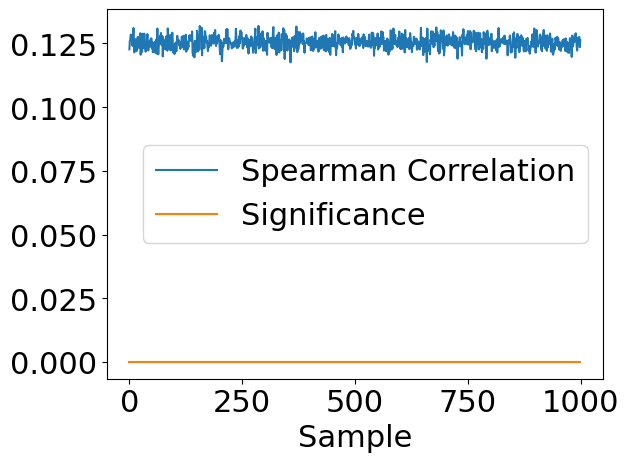

In [8]:
plt.plot(corrs, label="Spearman Correlation")
plt.plot(p_values, label="Significance")

plt.legend()

plt.xlabel("Sample")


## Network figure

In [18]:
#Read in assembly data into a dictionary, {ID:MA_value}
MA_df = pd.read_csv("../Data/AssemblyValues/assigneeCpds_AssemblyGo.csv")
assignee_cpd_MA_links = dict(zip(MA_df["label"], MA_df["MA_assemblyGo"]))

MA_df = pd.read_csv("../Data/AssemblyValues/authorcpds_AssemblyGo.csv")
author_cpd_MA_links = dict(zip(MA_df["label"], MA_df["MA_assemblyGo"]))

cpd_MA_links = {**assignee_cpd_MA_links, **author_cpd_MA_links}

MA_df = pd.DataFrame(cpd_MA_links.items(), columns=["label", "MA_assemblyGo"])

print(MA_df)

                   label  MA_assemblyGo
0        SCHEMBL10000004           13.0
1        SCHEMBL10000028           25.0
2        SCHEMBL10000029           20.0
3        SCHEMBL10000030           20.0
4        SCHEMBL10000031           19.0
...                  ...            ...
2711114   SCHEMBL9999904           15.0
2711115    SCHEMBL999991            7.0
2711116   SCHEMBL9999925           13.0
2711117   SCHEMBL9999926           14.0
2711118    SCHEMBL999994            7.0

[2711119 rows x 2 columns]


In [19]:
### ID/Degree relation: use 2015-2019 full ID list to find final degree value
full_id_degrees = pickle.load(file=open("/Volumes/Macintosh HD 4/SureChemBL/Degrees/full_id_degrees_2015_2019.p", "rb"))

print(list(full_id_degrees.items())[0:5])

[('SCHEMBL8038039', [418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418]), ('SCHEMBL656810', [1877, 1877, 1877, 3744, 7513, 9389, 9389, 9389, 13151, 15023, 16895, 16895, 20644, 20644, 20644, 20644, 22525, 22525, 22525, 24406, 24406, 24406, 26278, 26278, 28153, 28153, 31932, 31932, 31932, 33832, 33832, 35734, 35734, 35734, 35734, 35734, 35734, 35734, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 37630, 39493, 39493, 43224, 43224, 43224, 43224, 43224]), ('SCHEMBL16387018', [103, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201

In [20]:
def get_degree(ID, full_id_degrees):
    if ID in full_id_degrees:
        return full_id_degrees[ID][-1]
    else:
        return -1

In [21]:
#Add degree values to MA dataframe
tqdm.pandas()

MA_df["degree"] = MA_df["label"].progress_apply(get_degree, args=(full_id_degrees,))

/usr/local/lib/python3.9/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████████████████████████| 2711119/2711119 [00:30<00:00, 88081.64it/s]


In [22]:
del(full_id_degrees)

In [23]:
#Filter out all -1 MAs (indicates these MAs were not sampled)

MA_df_filtered = MA_df[MA_df["MA_assemblyGo"] > 0]

## Also where degrees are greater than 0

MA_df_filtered = MA_df_filtered[MA_df_filtered["degree"] > 0]


SpearmanrResult(correlation=-0.05327862379369209, pvalue=0.0)


/usr/local/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


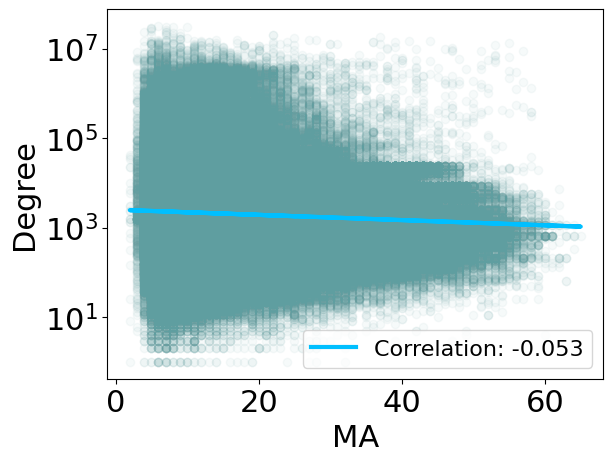

In [30]:
#Visual representation of 0 correlation (lol)
plt.Figure(figsize=(10,10))

plt.yscale("log")

plt.scatter(MA_df_filtered["MA_assemblyGo"], MA_df_filtered["degree"], color="cadetblue", alpha=0.05)
# sns.kdeplot(data=MA_df_filtered, x="MA_assemblyGo", y="degree", fill=True, color="cadetblue", alpha=0.5)

#plt.plot(X, Y_pred, linewidth=3, color="springgreen")
slope, intercept = np.polyfit(MA_df_filtered["MA_assemblyGo"], np.log(MA_df_filtered["degree"]), 1)

##Calculate Spearman correlation (not assuming normality)
spearman_corr = stats.spearmanr(MA_df_filtered["MA_assemblyGo"], MA_df_filtered["degree"])

plt.plot(MA_df_filtered["MA_assemblyGo"], np.exp((slope*MA_df_filtered["MA_assemblyGo"]) + intercept), 
        color="deepskyblue", linewidth=3, label="Correlation: " + str(round(spearman_corr[0], 3)))

print(spearman_corr)

plt.xlabel("MA")
plt.ylabel("Degree")
plt.legend(prop={"size":16})

In [12]:
#Store spearman correlation (if this goes below 0, then I'm confident it's not correlated)
corrs = []
p_values = []

for i in tqdm(range(1000)):
    # Keep 80% of sample each bootstrap
    sub_df = MA_df_filtered.sample(frac=0.8)
    spearman_corr = stats.spearmanr(sub_df["MA_assemblyGo"], sub_df["degree"])

    corrs.append(spearman_corr[0])
    p_values.append(spearman_corr[1])

100%|██████████| 1000/1000 [05:40<00:00,  2.94it/s]


Text(0.5, 1.0, 'Degree/MA Bootstrap')

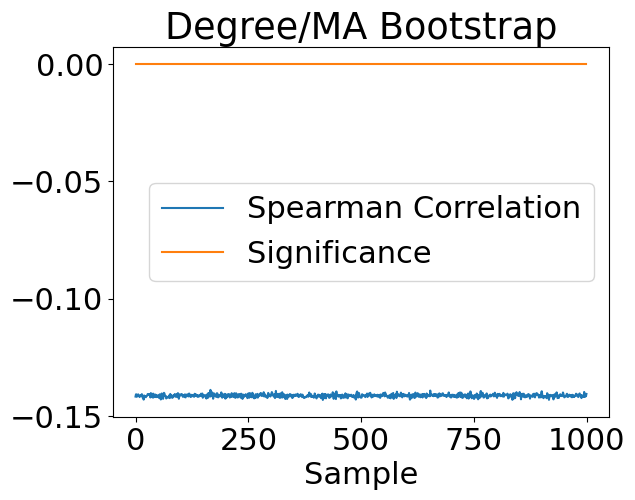

In [13]:
plt.plot(corrs, label="Spearman Correlation")
plt.plot(p_values, label="Significance")

plt.legend()

plt.xlabel("Sample")
plt.title("Degree/MA Bootstrap")


### Individual Researchers

In [3]:
results_df = pd.read_csv("../Data/Patents/patent_MA_results.csv")

100%|█████████████████████████████████████| 71587/71587 [23:09<00:00, 51.53it/s]


Text(0, 0.5, 'Patents')

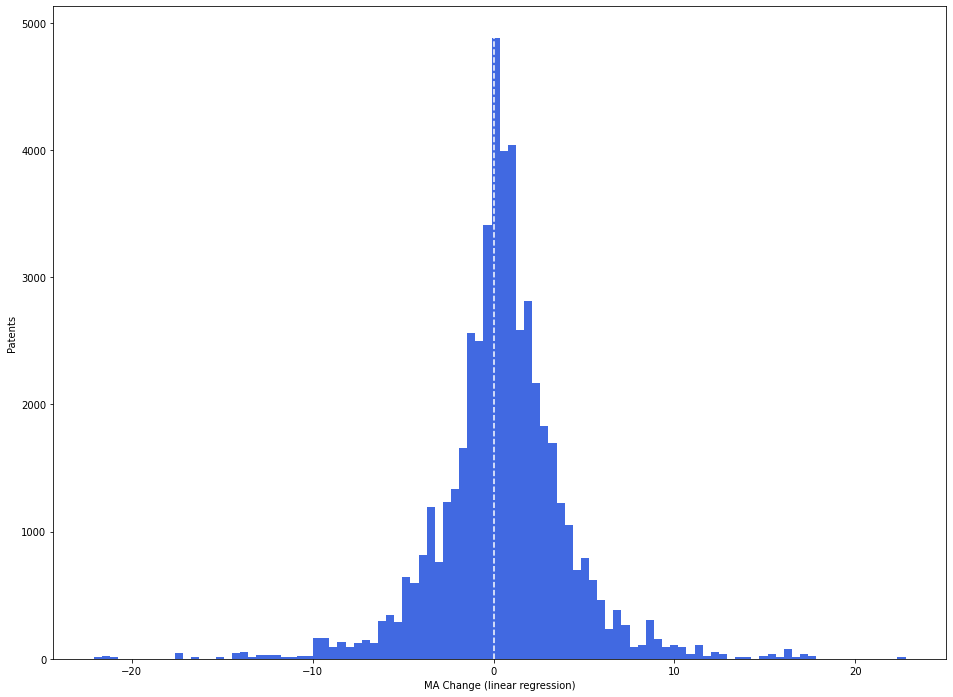

In [6]:
#Alternative graphing (finding slope change in MA)
linear_regressor = LinearRegression()

author_MA_slopes = []

for author in tqdm(list(results_df["author"].unique())):
    sub_df = results_df[results_df["author"] == author]
    if len(sub_df) > 10:

        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_avg"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            #Calculate deltaMA (change in MA of linear regression, taking into consideration negative slopes)
            author_MA_slopes.extend([reg.coef_[0][0] * (max(X) - min(X))[0]] * len(sub_df))
                        
        except ValueError as e:
            pass

plt.figure(figsize=(16,12))


plt.hist(author_MA_slopes, bins=100, color="royalblue")
plt.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--")
plt.xlabel("MA Change (linear regression)")
plt.ylabel("Patents")
# plt.title("Average MA changes - Authors", color="skyblue")


In [29]:
# Check percentile of 0
print("Percentile of 0 value", stats.percentileofscore(author_MA_slopes, 0, kind="rank"))
print("Mean:", np.mean(author_MA_slopes))
print("Std:", np.std(author_MA_slopes))

Percentile of 0 value 40.3304372030141
Mean: 0.5141305491772047
Std: 3.6134512536558443


## Assignees

100%|█████████████████████████████████████████| 833/833 [00:18<00:00, 45.13it/s]


Text(0, 0.5, 'Patents')

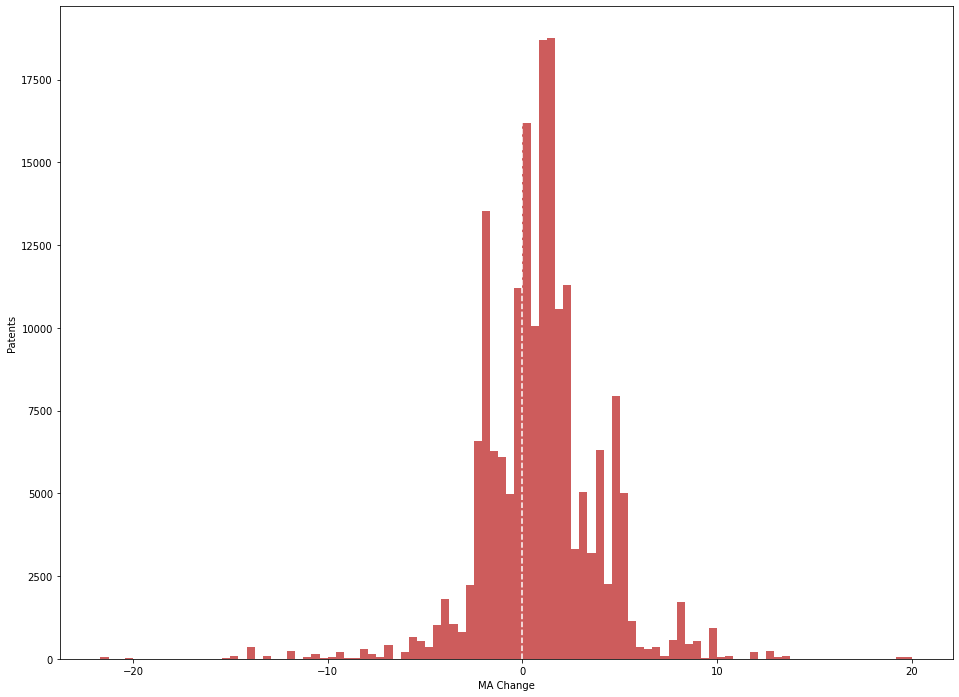

In [4]:
#Alternative graphing (finding slope change in MA)
linear_regressor = LinearRegression()

assignee_MA_slopes = []
counts = []

for assignee in tqdm(list(results_df["assignees"].unique())):
    sub_df = results_df[results_df["assignees"] == assignee]
    if len(sub_df) > 10:

        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_avg"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            r2 = reg.score(X, Y)

            assignee_MA_slopes.extend([reg.coef_[0][0] * (max(X) - min(X))[0]]*len(sub_df))
                        
        except ValueError as e:
            pass

plt.figure(figsize=(16,12))


plt.hist(assignee_MA_slopes, bins=100, histtype="bar", color="indianred")
plt.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--")
plt.xlabel("MA Change")
plt.ylabel("Patents")
# plt.title("Average MA changes - Assignees", color="indianred")


100%|██████████| 833/833 [00:13<00:00, 61.99it/s]


Text(0, 0.5, 'Patents')

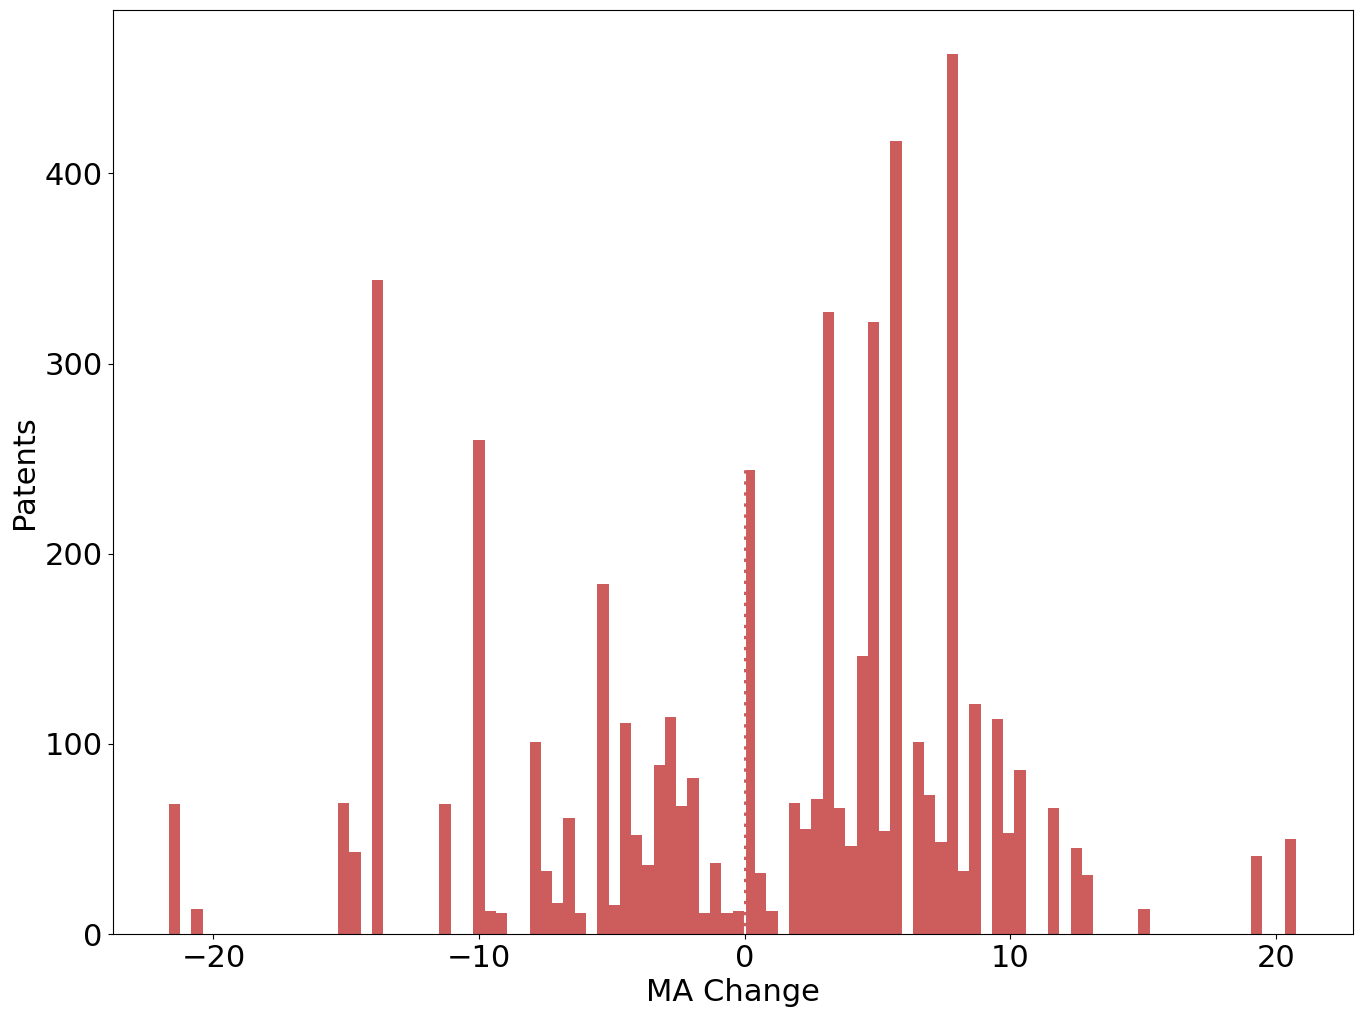

In [5]:
#Alternative graphing (finding slope change in MA)
linear_regressor = LinearRegression()

assignee_MA_slopes = []
counts = []

for assignee in tqdm(list(results_df["assignees"].unique())):
    sub_df = results_df[results_df["assignees"] == assignee]
    if len(sub_df) > 10:

        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_avg"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            r2 = reg.score(X, Y)

            if (r2 >= 0.25):

                #Calculate deltaMA (change in MA of linear regression, taking into consideration negative slopes)
                assignee_MA_slopes.extend([reg.coef_[0][0] * (max(X) - min(X))[0]]*len(sub_df))
                        
        except ValueError as e:
            pass

plt.figure(figsize=(16,12))


plt.hist(assignee_MA_slopes, bins=100, histtype="bar", color="indianred")
plt.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--")
plt.xlabel("MA Change")
plt.ylabel("Patents")
# plt.title("Average MA changes - Assignees", color="indianred")


In [28]:
# Check percentile of 0
print("Percentile of 0 value", stats.percentileofscore(assignee_MA_slopes, 0, kind="rank"))
print("Mean:", np.mean(assignee_MA_slopes))
print("Std:", np.std(assignee_MA_slopes))

Percentile of 0 value 32.08522583391253
Mean: 0.9944440979489239
Std: 2.951451200625727


## Classification

In [7]:
def classification_to_list(classification):
    try:
        return ast.literal_eval(classification)
    except ValueError:
        return []
    except SyntaxError:
        return classification.strip('][').split(',')

In [8]:
tqdm.pandas()

results_df["classification"] = results_df["classification"].progress_apply(classification_to_list)

/usr/local/lib/python3.9/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|████████████████████████████████| 186485/186485 [00:10<00:00, 17420.61it/s]


In [9]:
#Explode classifications
results_df = results_df.explode("classification")

In [10]:
## Remove backslash and two numbers after it (and put them in a different column, in case they are useful later...)
def filter_classification(classification):
    try:
        return classification.split("/")[0]
    except AttributeError:
        return ""

In [11]:
tqdm.pandas()

results_df["filtered_classification"] = results_df["classification"].progress_apply(filter_classification)

print(results_df)

100%|█████████████████████████████| 1247658/1247658 [00:03<00:00, 325443.34it/s]

        Unnamed: 0  Unnamed: 0.1              ID            author  \
0                0           276  US-10034442-B2  AARDEN HARRIETTE   
0                0           276  US-10034442-B2  AARDEN HARRIETTE   
0                0           276  US-10034442-B2  AARDEN HARRIETTE   
0                0           276  US-10034442-B2  AARDEN HARRIETTE   
1               10           277  US-10034442-B2           BAR AMI   
...            ...           ...             ...               ...   
186483     4152321        907681   US-9751966-B2    ZWEIG ANDREW M   
186483     4152321        907681   US-9751966-B2    ZWEIG ANDREW M   
186483     4152321        907681   US-9751966-B2    ZWEIG ANDREW M   
186484     4152322        907682    US-4914171-A    ZWEIG ANDREW M   
186484     4152322        907682    US-4914171-A    ZWEIG ANDREW M   

                          assignees  \
0       SEMINIS_VEGETABLE_SEEDS_INC   
0       SEMINIS_VEGETABLE_SEEDS_INC   
0       SEMINIS_VEGETABLE_SEEDS_INC   
0  

100%|███████████████████████████████████████| 2926/2926 [06:54<00:00,  7.06it/s]


Text(0, 0.5, 'Count')

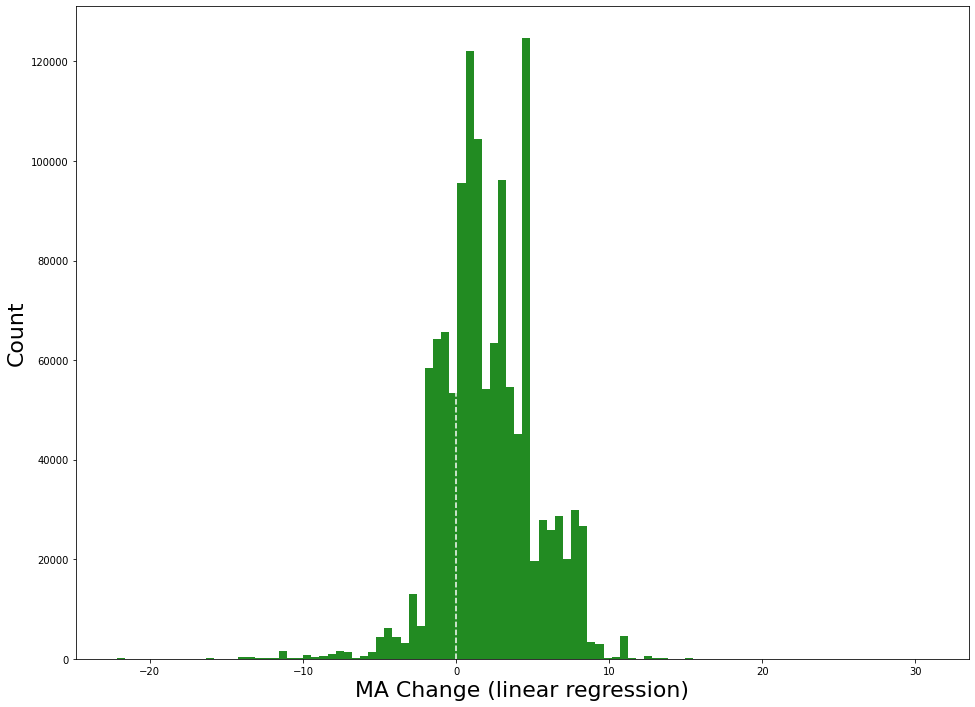

In [12]:
#Alternative graphing (finding slope change in MA)
linear_regressor = LinearRegression()

classification_MA_slopes = []

for c in tqdm(list(results_df["filtered_classification"].unique())):
    sub_df = results_df[results_df["filtered_classification"] == c]
    if len(sub_df) > 10:

        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_avg"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            #Calculate deltaMA (change in MA of linear regression, taking into consideration negative slopes)
            classification_MA_slopes.extend([reg.coef_[0][0] * (max(X) - min(X))[0]]*len(sub_df))
                        
        except ValueError as e:
            pass

plt.figure(figsize=(16,12))


plt.hist(classification_MA_slopes, bins=100, color="forestgreen")
plt.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--")
plt.xlabel("MA Change (linear regression)", fontsize=22)
plt.ylabel("Count", fontsize=22)


100%|██████████| 2923/2923 [04:53<00:00,  9.96it/s]


Text(0, 0.5, 'Count')

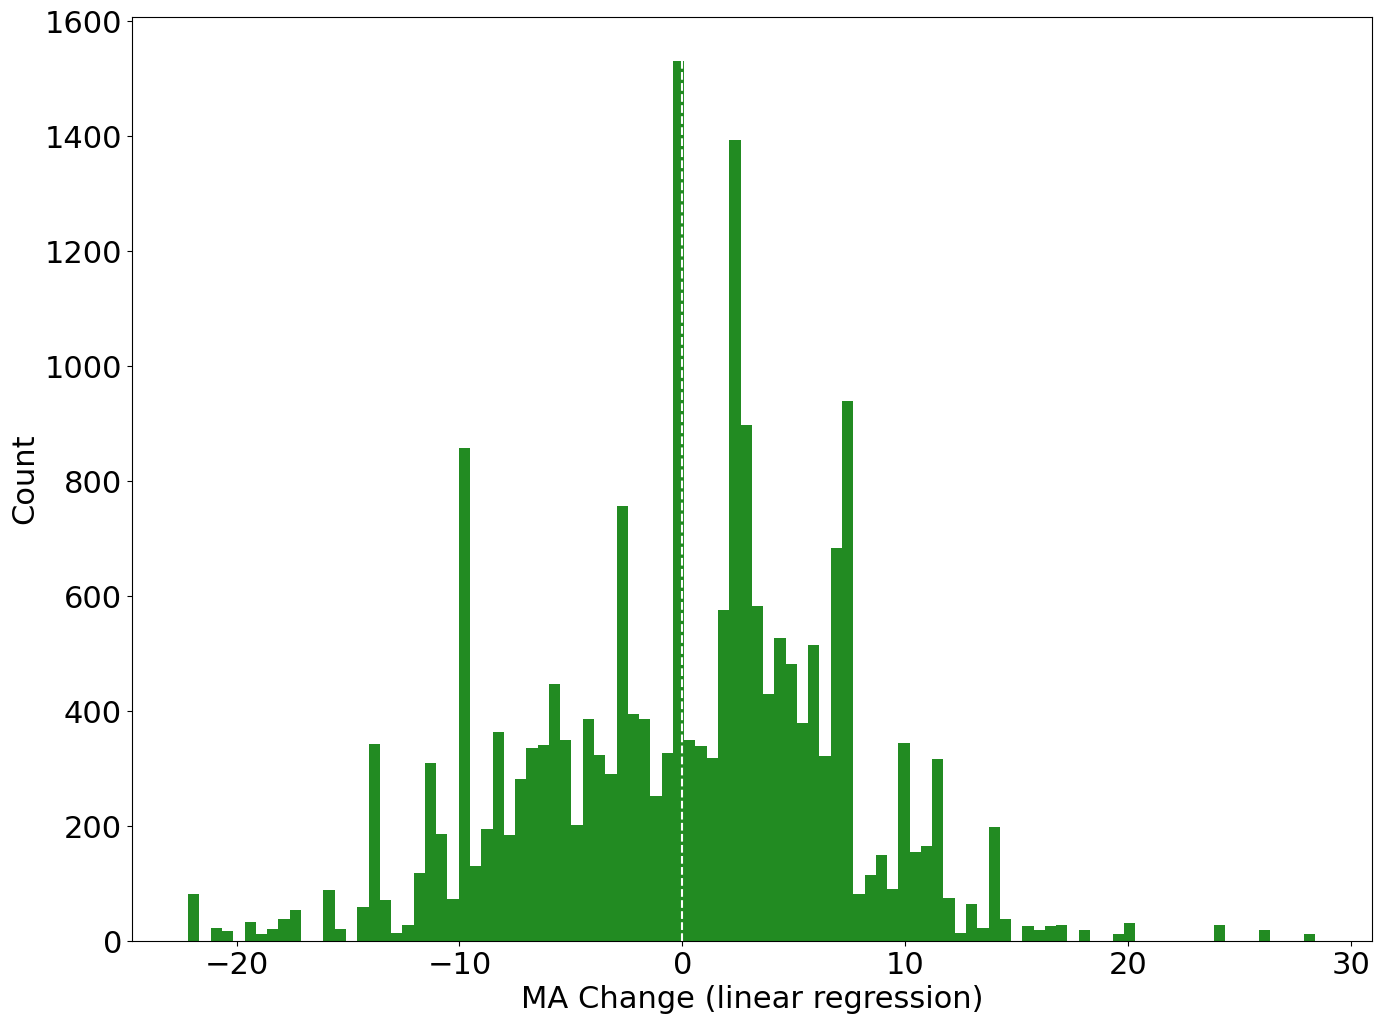

In [12]:
#Alternative graphing (finding slope change in MA)
linear_regressor = LinearRegression()

classification_MA_slopes = []

for c in tqdm(list(results_df["filtered_classification"].unique())):
    sub_df = results_df[results_df["filtered_classification"] == c]
    if len(sub_df) > 10:

        X = sub_df["date_ordinal"].values.reshape(-1,1)
        Y = sub_df["MA_avg"].values.reshape(-1,1)
        try:
            reg = linear_regressor.fit(X, Y)
            Y_pred = linear_regressor.predict(X)

            r2 = reg.score(X,Y)

            if r2 >= 0.25:
                #Calculate deltaMA (change in MA of linear regression, taking into consideration negative slopes)
                classification_MA_slopes.extend([reg.coef_[0][0] * (max(X) - min(X))[0]]*len(sub_df))
                        
        except ValueError as e:
            pass

plt.figure(figsize=(16,12))


plt.hist(classification_MA_slopes, bins=100, color="forestgreen")
plt.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--")
plt.xlabel("MA Change (linear regression)", fontsize=22)
plt.ylabel("Count", fontsize=22)


In [27]:
# Check percentile of 0
print("Percentile of 0 value", stats.percentileofscore(classification_MA_slopes, 0, kind="rank"))
print("Mean:", np.mean(classification_MA_slopes))
print("Std:", np.std(classification_MA_slopes))

Percentile of 0 value 21.552234698459344
Mean: 2.1479832168081
Std: 3.0609142237426346


## Full Figure

Price & Degree on top (with inset in price), and the three histograms on bottom

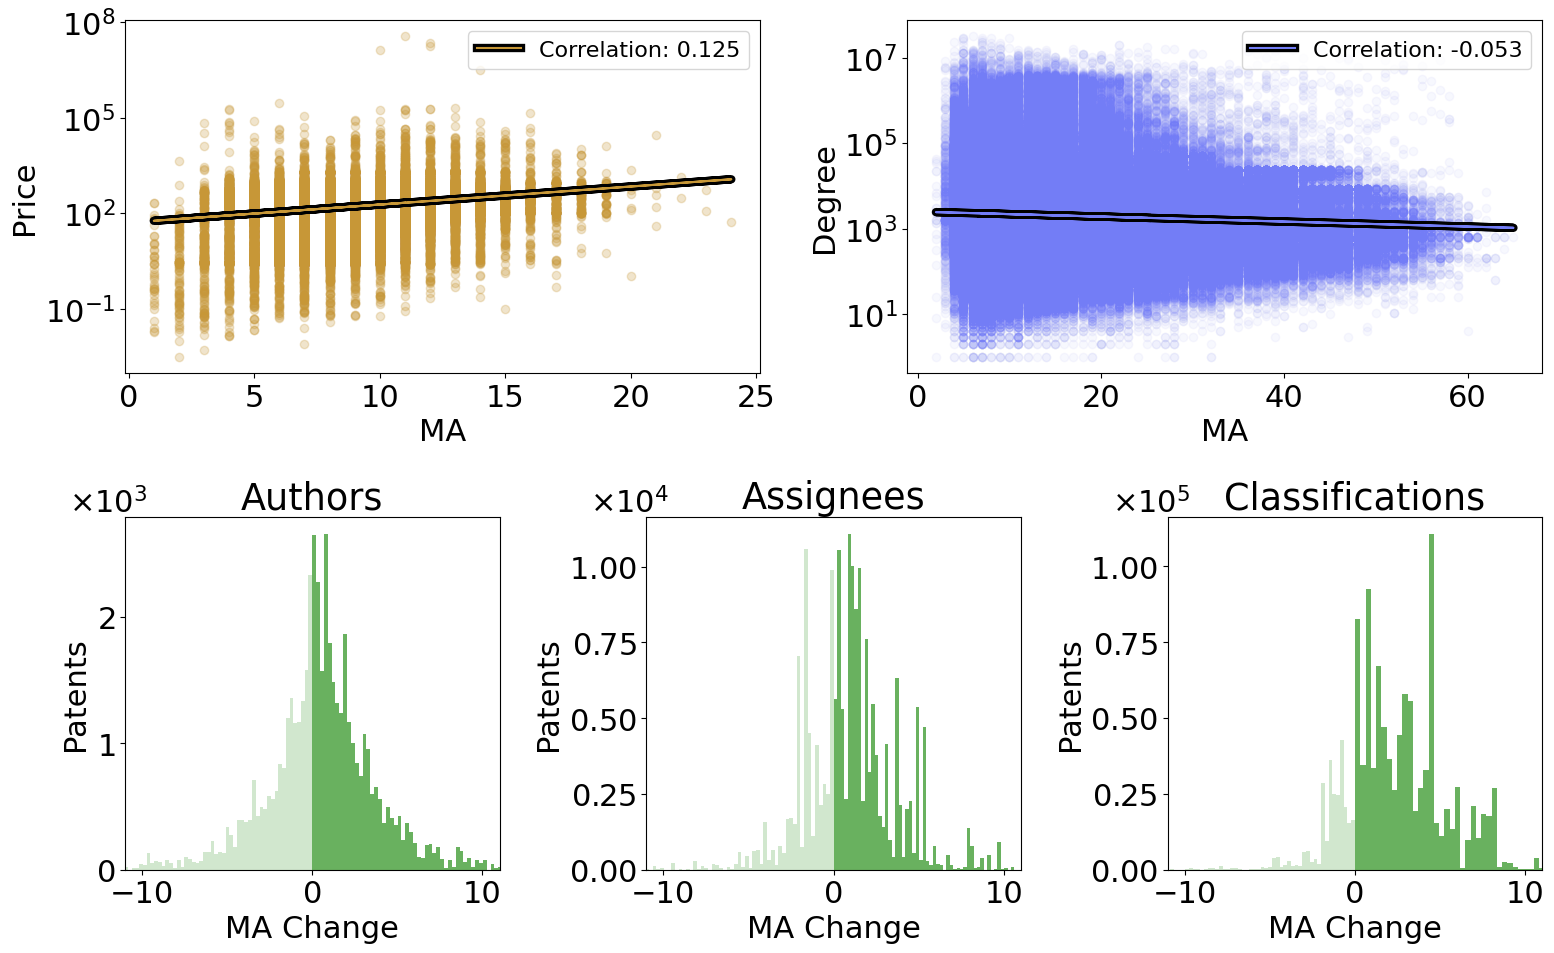

In [26]:
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as pe

palette = ["#e072b5",
"#69b15f",
"#737df6",
"#c79737",
"#b67ae4",
"#e57368",
"#799ddb"]

gs = gridspec.GridSpec(2,6)

fig = plt.figure(figsize=(16,10))

## Cost 
ax1 = fig.add_subplot(gs[0,0:3])

cost_df_filtered = cost_df_filtered.sort_values("price")

ax1.scatter(cost_df_filtered["MA"], cost_df_filtered["price"], alpha=0.25, color=palette[3])

slope, intercept = np.polyfit(cost_df_filtered["MA"], np.log(cost_df_filtered["price"]), 1)

##Calculate Pearson correlation & Spearman (not assuming normality)
spearman_corr = stats.spearmanr(cost_df_filtered["MA"], cost_df_filtered["price"])

ax1.plot(cost_df_filtered["MA"], np.exp((slope*cost_df_filtered["MA"]) + intercept), color=palette[3],
        label="Correlation: " + str(round(spearman_corr[0], 3)), 
        path_effects=[pe.Stroke(linewidth=6, foreground="k"), pe.Normal()])

ax1.set_yscale("log")
ax1.set_xlabel("MA")
ax1.set_ylabel("Price")
ax1.legend(prop={"size":16}, loc="upper right")

## Degree
ax2 = fig.add_subplot(gs[0,3:])

ax2.scatter(MA_df_filtered["MA_assemblyGo"], MA_df_filtered["degree"], color=palette[2], alpha=0.05)

slope, intercept = np.polyfit(MA_df_filtered["MA_assemblyGo"], np.log(MA_df_filtered["degree"]), 1)

##Calculate Spearman correlation (not assuming normality)
spearman_corr = stats.spearmanr(MA_df_filtered["MA_assemblyGo"], MA_df_filtered["degree"])

ax2.plot(MA_df_filtered["MA_assemblyGo"], np.exp((slope*MA_df_filtered["MA_assemblyGo"]) + intercept), 
        color=palette[2], label="Correlation: " + str(round(spearman_corr[0], 3)),
        path_effects=[pe.Stroke(linewidth=6, foreground="k"), pe.Normal()])

ax2.set_yscale("log")
ax2.set_xlabel("MA")
ax2.set_ylabel("Degree")
ax2.legend(prop={"size":16}, loc="upper right")

## Author histogram
ax3 = fig.add_subplot(gs[1,0:2])

ax3.hist([x for x in author_MA_slopes if x <= 0], bins=100, color=palette[1], alpha=0.3)
ax3.hist([x for x in author_MA_slopes if x > 0], bins=100, color=palette[1])
# ax3.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--", linewidth=3)

ax3.set_xlabel("MA Change")
ax3.set_ylabel("Patents")
ax3.set_xbound(-11, 11)
ax3.set_title("Authors")
ax3.ticklabel_format(axis="y", style="sci", scilimits=(-2,2))
ax3.yaxis.major.formatter._useMathText = True
ax3.get_yaxis().get_offset_text().set_position((-0.15, 0))

## Assignee histogram
ax4 = fig.add_subplot(gs[1,2:4])

ax4.hist([x for x in assignee_MA_slopes if x <= 0], bins=100, histtype="bar", color=palette[1], alpha=0.3)
ax4.hist([x for x in assignee_MA_slopes if x > 0], bins=100, histtype="bar", color=palette[1])
# ax4.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--", linewidth=3)

ax4.set_xlabel("MA Change")
ax4.set_ylabel("Patents")
ax4.set_xbound(-11, 11)
ax4.set_title("Assignees")
ax4.ticklabel_format(axis="y", style="sci", scilimits=(-2,2))
ax4.yaxis.major.formatter._useMathText = True
ax4.get_yaxis().get_offset_text().set_position((-0.15, 0))


## Classification histogram
ax5 = fig.add_subplot(gs[1,4:])

ax5.hist([x for x in classification_MA_slopes if x <= 0], bins=100, histtype="bar", color=palette[1], alpha=0.3)
ax5.hist([x for x in classification_MA_slopes if x > 0], bins=100, histtype="bar", color=palette[1])
# ax5.axvline(x=0, ymin=0, ymax=70, color="white", linestyle="--", linewidth=3)

ax5.set_xlabel("MA Change")
ax5.set_ylabel("Patents")
ax5.set_xbound(-11, 11)
ax5.set_title("Classifications")
ax5.ticklabel_format(axis="y", style="sci", scilimits=(-2,2))
ax5.yaxis.major.formatter._useMathText = True
ax5.get_yaxis().get_offset_text().set_position((-0.15, 0))


plt.tight_layout()
